<a href="https://colab.research.google.com/github/syahvan/credit-risk-prediction/blob/main/Credit_Risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CREDIT RISK PREDICTION WITH XGBOOST

# Introduction

Credit Risk Prediction adalah suatu metode efektif untuk mengevaluasi potensi seorang calon peminjam dalam melunasi pinjaman yang diberikan. Dataset yang digunakan berasal dari LendingClub, sebuah perusahaan Peer-to-Peer (P2P) Lending yang berbasis di Amerika Serikat.

Dengan memanfaatkan data historis pinjaman yang diberikan oleh LendingClub, termasuk informasi mengenai keberhasilan atau kegagalan peminjam dalam membayar pinjaman, kita dapat mengembangkan model prediksi yang mampu memproyeksikan kemungkinan seorang peminjam untuk melunasi pinjaman di masa depan. Dengan menggunakan pendekatan ini, ketika kita menghadapi calon pelanggan baru di waktu yang akan datang, kita dapat melakukan penilaian terhadap kemampuan mereka dalam membayar pinjaman tersebut.





# Import Library


In [ ]:
import numpy as np

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 99)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Dataset

In [ ]:
data_raw = pd.read_csv('/content/drive/MyDrive/Dataset/Credit/loan_data_2007_2014.csv', index_col=0)

# Explore Dataset

In [ ]:
data_raw.shape

(466285, 74)

In [ ]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 466285 entries, 0 to 466284
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           466285 non-null  int64  
 1   member_id                    466285 non-null  int64  
 2   loan_amnt                    466285 non-null  int64  
 3   funded_amnt                  466285 non-null  int64  
 4   funded_amnt_inv              466285 non-null  float64
 5   term                         466285 non-null  object 
 6   int_rate                     466285 non-null  float64
 7   installment                  466285 non-null  float64
 8   grade                        466285 non-null  object 
 9   sub_grade                    466285 non-null  object 
 10  emp_title                    438697 non-null  object 
 11  emp_length                   445277 non-null  object 
 12  home_ownership               466285 non-null  object 
 13 

In [ ]:
data_raw.sample()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
113304,6318025,7849585,10000,10000,10000.0,36 months,15.22,347.74,C,C3,usCalibration,2 years,RENT,58000.0,Not Verified,Jul-13,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 07/13/13 > It one of times...,debt_consolidation,Life Refinance,928xx,CA,20.63,0.0,Aug-01,0.0,NaN,NaN,10.0,0.0,12394,70.4,11.0,f,0.0,0.0,11506.32579,11506.33,10000.0,1506.33,0.0,0.0,0.0,Sep-14,6988.57,NaN,Mar-15,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,0.0,40541.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17600.0,NaN,NaN,NaN


In [ ]:
data_raw.id.nunique()

466285

In [ ]:
data_raw.member_id.nunique()

466285

Terlihat bahwa tidak ada `id` atau `member_id` yang duplikat, artinya setiap baris sudah mewakili satu individu.

Selanjutnya, pembuangan fitur-fitur yang tidak berguna dilakukan. Contohnya seperti fitur yang merupakan id unik, berupa free text, nilainya kosong semua (NULL), dsb.

In [ ]:
cols_to_drop = [
    # unique id
    'id'
    , 'member_id'

    # free text
    , 'url'
    , 'desc'

    # all null / constant / others
    , 'zip_code'
    , 'annual_inc_joint'
    , 'dti_joint'
    , 'verification_status_joint'
    , 'open_acc_6m'
    , 'open_il_6m'
    , 'open_il_12m'
    , 'open_il_24m'
    , 'mths_since_rcnt_il'
    , 'total_bal_il'
    , 'il_util'
    , 'open_rv_12m'
    , 'open_rv_24m'
    , 'max_bal_bc'
    , 'all_util'
    , 'inq_fi'
    , 'total_cu_tl'
    , 'inq_last_12m'

    # expert judgment
    , 'sub_grade'
]

In [ ]:
data = data_raw.drop(cols_to_drop, axis=1)

In [ ]:
data.sample(5)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
274874,14000,14000,14000.0,36 months,13.35,474.08,C,Dispatcher,9 years,MORTGAGE,85500.00,Source Verified,Oct-14,Current,n,debt_consolidation,Debt consolidation,WY,18.09,0.0,Feb-05,3.0,NaN,NaN,12.0,0.0,10607,46.1,34.0,f,9206.32,9206.32,6626.74,6626.74,4793.68,1833.06,0.0,0.00,0.0000,Dec-15,474.08,Jan-16,Jan-16,0.0,NaN,1,INDIVIDUAL,0.0,381.0,339059.0,23000.0
424639,35000,35000,35000.0,36 months,11.99,1162.34,B,BUS OPERATOR,10+ years,MORTGAGE,114320.27,Verified,Mar-14,Current,n,home_improvement,Home improvement,NY,2.76,0.0,Jan-95,0.0,44.0,NaN,5.0,0.0,49307,16.6,22.0,f,16116.71,16116.71,24409.14,24409.14,18883.29,5525.85,0.0,0.00,0.0000,Jan-16,1162.34,Jan-16,Jan-16,0.0,44.0,1,INDIVIDUAL,0.0,15955.0,677490.0,54600.0
26419,14000,14000,13650.0,36 months,7.88,437.94,A,Effective Graphics,7 years,RENT,60000.00,Source Verified,Aug-10,Fully Paid,n,debt_consolidation,pay my debt,CA,15.34,0.0,Nov-88,2.0,NaN,NaN,7.0,0.0,14922,59.2,20.0,f,0.00,0.00,15764.21,15370.10,14000.00,1764.21,0.0,0.00,0.0000,Sep-13,457.56,NaN,Dec-14,0.0,NaN,1,INDIVIDUAL,0.0,NaN,NaN,NaN
183419,14400,14400,14400.0,36 months,18.49,524.15,D,GE aviation Terre Haute,9 years,MORTGAGE,40000.00,Source Verified,Nov-12,Charged Off,n,other,Good investment choice #1,IN,28.32,0.0,Feb-05,2.0,NaN,NaN,12.0,0.0,6612,84.8,32.0,f,0.00,0.00,15564.96,15564.96,10474.94,4187.68,0.0,902.34,162.4212,Apr-15,524.15,NaN,Aug-15,0.0,NaN,1,INDIVIDUAL,0.0,0.0,47377.0,7800.0
69858,7500,7500,7500.0,36 months,18.55,273.22,D,NaN,10+ years,MORTGAGE,52000.00,Verified,Nov-13,Current,n,debt_consolidation,Credit Consolidation,CA,10.85,3.0,Nov-02,1.0,5.0,NaN,6.0,0.0,7001,82.4,19.0,f,2513.53,2513.53,7103.57,7103.57,4986.47,2117.10,0.0,0.00,0.0000,Jan-16,273.22,Feb-16,Jan-16,0.0,12.0,1,INDIVIDUAL,0.0,0.0,95583.0,8500.0


# Define Target Variable

Dalam project credit risk modeling, tujuan utama adalah untuk melakukan prediksi terhadap suatu individu akan kemampuan mereka untuk melakukan pembayaran terhadap pinjaman/kredit yang diberikan. Oleh karena itu, variabel target yang digunakan harus mencerminkan kemampuan individu dalam hal tersebut.

Dalam dataset ini, variabel `loan_status` adalah variabel yang dapat dijadikan variabel target karena mencerminkan performa masing-masing individu dalam melakukan pembayaran terhadap pinjaman/kredit selama ini.

In [ ]:
data.loan_status.value_counts(normalize=True)*100

Current                                                48.087757
Fully Paid                                             39.619332
Charged Off                                             9.109236
Late (31-120 days)                                      1.479782
In Grace Period                                         0.674695
Does not meet the credit policy. Status:Fully Paid      0.426349
Late (16-30 days)                                       0.261214
Default                                                 0.178432
Does not meet the credit policy. Status:Charged Off     0.163205
Name: loan_status, dtype: float64

Dapat dilihat bahwa variabel `loan_status` memiliki beberapa nilai:

* `Current` artinya pembayaran lancar
* `Charged Off` artinya pembayaran macet sehingga dihapusbukukan
* `Late` artinya pembayaran telat dilakukan
* `In Grace Period` artinya dalam masa tenggang; `Fully Paid` artinya pembayaran lunas
* `Default` artinya pembayaran macet

Dari definisi-definisi tersebut, masing-masing individu dapat ditandai apakah mereka merupakan `bad loan` (peminjam yang buruk) atau `good loan` (peminjam yang baik)

Definisi bad dan good loan terkadang bisa berbeda tergantung dari kebutuhan bisnis. Pada contoh ini, saya menggunakan keterlambatan pembayaran di atas 30 hari dan yang lebih buruk dari itu sebagai penanda bad loan.

In [ ]:
bad_status = [
    'Charged Off'
    , 'Default'
    , 'Does not meet the credit policy. Status:Charged Off'
    , 'Late (31-120 days)'
]

data['bad_flag'] = np.where(data['loan_status'].isin(bad_status), 1, 0)

In [ ]:
data['bad_flag'].value_counts(normalize=True)*100

0    89.069346
1    10.930654
Name: bad_flag, dtype: float64

Setelah melakukan flagging terhadap bad/good loan, dapat dilihat bahwa jumlah individu yang ditandai sebagai bad loan jauh lebih sedikit daripada good loan. Hal ini menyebabkan problem ini menjadi problem imbalanced dataset.

Jangan lupa untuk membuang kolom asal `loan_status`

In [ ]:
data.drop('loan_status', axis=1, inplace=True)

# Cleaning, Preprocessing, Feature Engineering

Pada step ini, dilakukan pembersihan/modifikasi beberapa fitur ke dalam format yang dapat digunakan untuk modeling.

### emp_length

Memodifikasi `emp_length`. Contoh: 4 years -> 4

In [ ]:
data['emp_length'].unique()

array(['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '6 years', '2 years', '7 years', nan],
      dtype=object)

In [ ]:
data['emp_length_int'] = data['emp_length'].str.replace('\+ years', '')
data['emp_length_int'] = data['emp_length_int'].str.replace('< 1 year', str(0))
data['emp_length_int'] = data['emp_length_int'].str.replace(' years', '')
data['emp_length_int'] = data['emp_length_int'].str.replace(' year', '')

In [ ]:
data['emp_length_int'] = data['emp_length_int'].astype(float)

In [ ]:
data.drop('emp_length', axis=1, inplace=True)

### term

Memodifikasi `term`. Contoh: 36 months -> 36

In [ ]:
data['term'].unique()

array([' 36 months', ' 60 months'], dtype=object)

In [ ]:
data['term_int'] = data['term'].str.replace(' months', '')
data['term_int'] = data['term_int'].astype(float)

In [ ]:
data.drop('term', axis=1, inplace=True)

### earliest_cr_line

Memodifikasi `earliest_cr_line` dari format bulan-tahun menjadi perhitungan berapa lama waktu berlalu sejak waktu tersebut. Untuk melakukan hal ini, umumnya digunakan reference date = hari ini. Namun, karena dataset ini merupakan dataset tahun 2007-2014, maka akan lebih relevan jika menggunakan reference date di sekitar tahun 2017. Dalam contoh ini, saya menggunakan tanggal 2017-12-01 sebagai reference date.

In [ ]:
data['earliest_cr_line'].head(3)

0    Jan-85
1    Apr-99
2    Nov-01
Name: earliest_cr_line, dtype: object

In [ ]:
data['earliest_cr_line_date'] = pd.to_datetime(data['earliest_cr_line'], format='%b-%y')
data['earliest_cr_line_date'].head(3)

0   1985-01-01
1   1999-04-01
2   2001-11-01
Name: earliest_cr_line_date, dtype: datetime64[ns]

In [ ]:
data['mths_since_earliest_cr_line'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - data['earliest_cr_line_date']) / np.timedelta64(1, 'M')))
data['mths_since_earliest_cr_line'].head(3)

0    395.0
1    224.0
2    193.0
Name: mths_since_earliest_cr_line, dtype: float64

In [ ]:
data['mths_since_earliest_cr_line'].describe()

count    466256.000000
mean        239.482430
std          93.974829
min        -612.000000
25%         183.000000
50%         225.000000
75%         285.000000
max         587.000000
Name: mths_since_earliest_cr_line, dtype: float64

Terlihat ada nilai yang aneh, yaitu negatif.

In [ ]:
data[data['mths_since_earliest_cr_line']<0][['earliest_cr_line', 'earliest_cr_line_date', 'mths_since_earliest_cr_line']].head(3)

,earliest_cr_line,earliest_cr_line_date,mths_since_earliest_cr_line
1580,Sep-62,2062-09-01,-537.0
1770,Sep-68,2068-09-01,-609.0
2799,Sep-64,2064-09-01,-561.0


Ternyata nilai negatif muncul karena fungsi Python salah menginterpretasikan tahun 62 menjadi tahun 2062, padahal seharusnya merupakan tahun 1962.

Untuk mengatasi hal ini, kita akan mengubah `earliest_cr_line_date` tersebut menjadi string dan mengganti angka tahun 20 menjadi 19 pada data `mths_since_earliest_cr_line` yang masih negatif.


In [ ]:
data['earliest_cr_line_date'] = data['earliest_cr_line_date'].astype(str)
data['earliest_cr_line_date'][data['mths_since_earliest_cr_line'] < 0] = data['earliest_cr_line_date'][data['mths_since_earliest_cr_line'] < 0].str.replace('20','19')
data['earliest_cr_line_date'] = pd.to_datetime(data['earliest_cr_line_date'])


In [ ]:
data[data['mths_since_earliest_cr_line']<0][['earliest_cr_line', 'earliest_cr_line_date', 'mths_since_earliest_cr_line']].head(3)

,earliest_cr_line,earliest_cr_line_date,mths_since_earliest_cr_line
1580,Sep-62,1962-09-01,-537.0
1770,Sep-68,1968-09-01,-609.0
2799,Sep-64,1964-09-01,-561.0


In [ ]:
data['mths_since_earliest_cr_line'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - data['earliest_cr_line_date']) / np.timedelta64(1, 'M')))
data['mths_since_earliest_cr_line'].head(3)

0    395.0
1    224.0
2    193.0
Name: mths_since_earliest_cr_line, dtype: float64

In [ ]:
data['mths_since_earliest_cr_line'].describe()

count    466256.000000
mean        242.491078
std          86.928944
min          73.000000
25%         184.000000
50%         226.000000
75%         285.000000
max         887.000000
Name: mths_since_earliest_cr_line, dtype: float64

In [ ]:
data.drop(['earliest_cr_line', 'earliest_cr_line_date'], axis=1, inplace=True)

### issue_d

Konsep preprocessing yang dilakukan sama dengan yang dilakukan terhadap variabel `earliest_cr_line`

In [ ]:
data['issue_d_date'] = pd.to_datetime(data['issue_d'], format='%b-%y')
data['mths_since_issue_d'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - data['issue_d_date']) / np.timedelta64(1, 'M')))

In [ ]:
data['mths_since_issue_d'].describe()

count    466285.000000
mean         51.255187
std          14.340154
min          36.000000
25%          41.000000
50%          47.000000
75%          57.000000
max         126.000000
Name: mths_since_issue_d, dtype: float64

In [ ]:
data.drop(['issue_d', 'issue_d_date'], axis=1, inplace=True)

### last_pymnt_d

Konsep preprocessing yang dilakukan sama dengan yang dilakukan terhadap variabel `earliest_cr_line`

In [ ]:
data['last_pymnt_d_date'] = pd.to_datetime(data['last_pymnt_d'], format='%b-%y')
data['mths_since_last_pymnt_d'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - data['last_pymnt_d_date']) / np.timedelta64(1, 'M')))

In [ ]:
data['mths_since_last_pymnt_d'].describe()

count    465909.000000
mean         31.294369
std          12.809898
min          23.000000
25%          23.000000
50%          24.000000
75%          35.000000
max         120.000000
Name: mths_since_last_pymnt_d, dtype: float64

In [ ]:
data.drop(['last_pymnt_d', 'last_pymnt_d_date'], axis=1, inplace=True)

### next_pymnt_d

Konsep preprocessing yang dilakukan sama dengan yang dilakukan terhadap variabel `earliest_cr_line`

In [ ]:
data['next_pymnt_d_date'] = pd.to_datetime(data['next_pymnt_d'], format='%b-%y')
data['mths_since_next_pymnt_d'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - data['next_pymnt_d_date']) / np.timedelta64(1, 'M')))

In [ ]:
data['mths_since_next_pymnt_d'].describe()

count    239071.000000
mean         22.738136
std           6.082298
min          21.000000
25%          22.000000
50%          22.000000
75%          22.000000
max         120.000000
Name: mths_since_next_pymnt_d, dtype: float64

In [ ]:
data.drop(['next_pymnt_d', 'next_pymnt_d_date'], axis=1, inplace=True)

### last_credit_pull_d

Konsep preprocessing yang dilakukan sama dengan yang dilakukan terhadap variabel `earliest_cr_line`

In [ ]:
data['last_credit_pull_d_date'] = pd.to_datetime(data['last_credit_pull_d'], format='%b-%y')
data['mths_since_last_credit_pull_d'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - data['last_credit_pull_d_date']) / np.timedelta64(1, 'M')))

In [ ]:
data['mths_since_last_credit_pull_d'].describe()

count    466243.000000
mean         27.045588
std           9.636423
min          23.000000
25%          23.000000
50%          23.000000
75%          25.000000
max         127.000000
Name: mths_since_last_credit_pull_d, dtype: float64

In [ ]:
data.drop(['last_credit_pull_d', 'last_credit_pull_d_date'], axis=1, inplace=True)

# Exploratory Data Analysis

### Correlation Check

<Axes: >

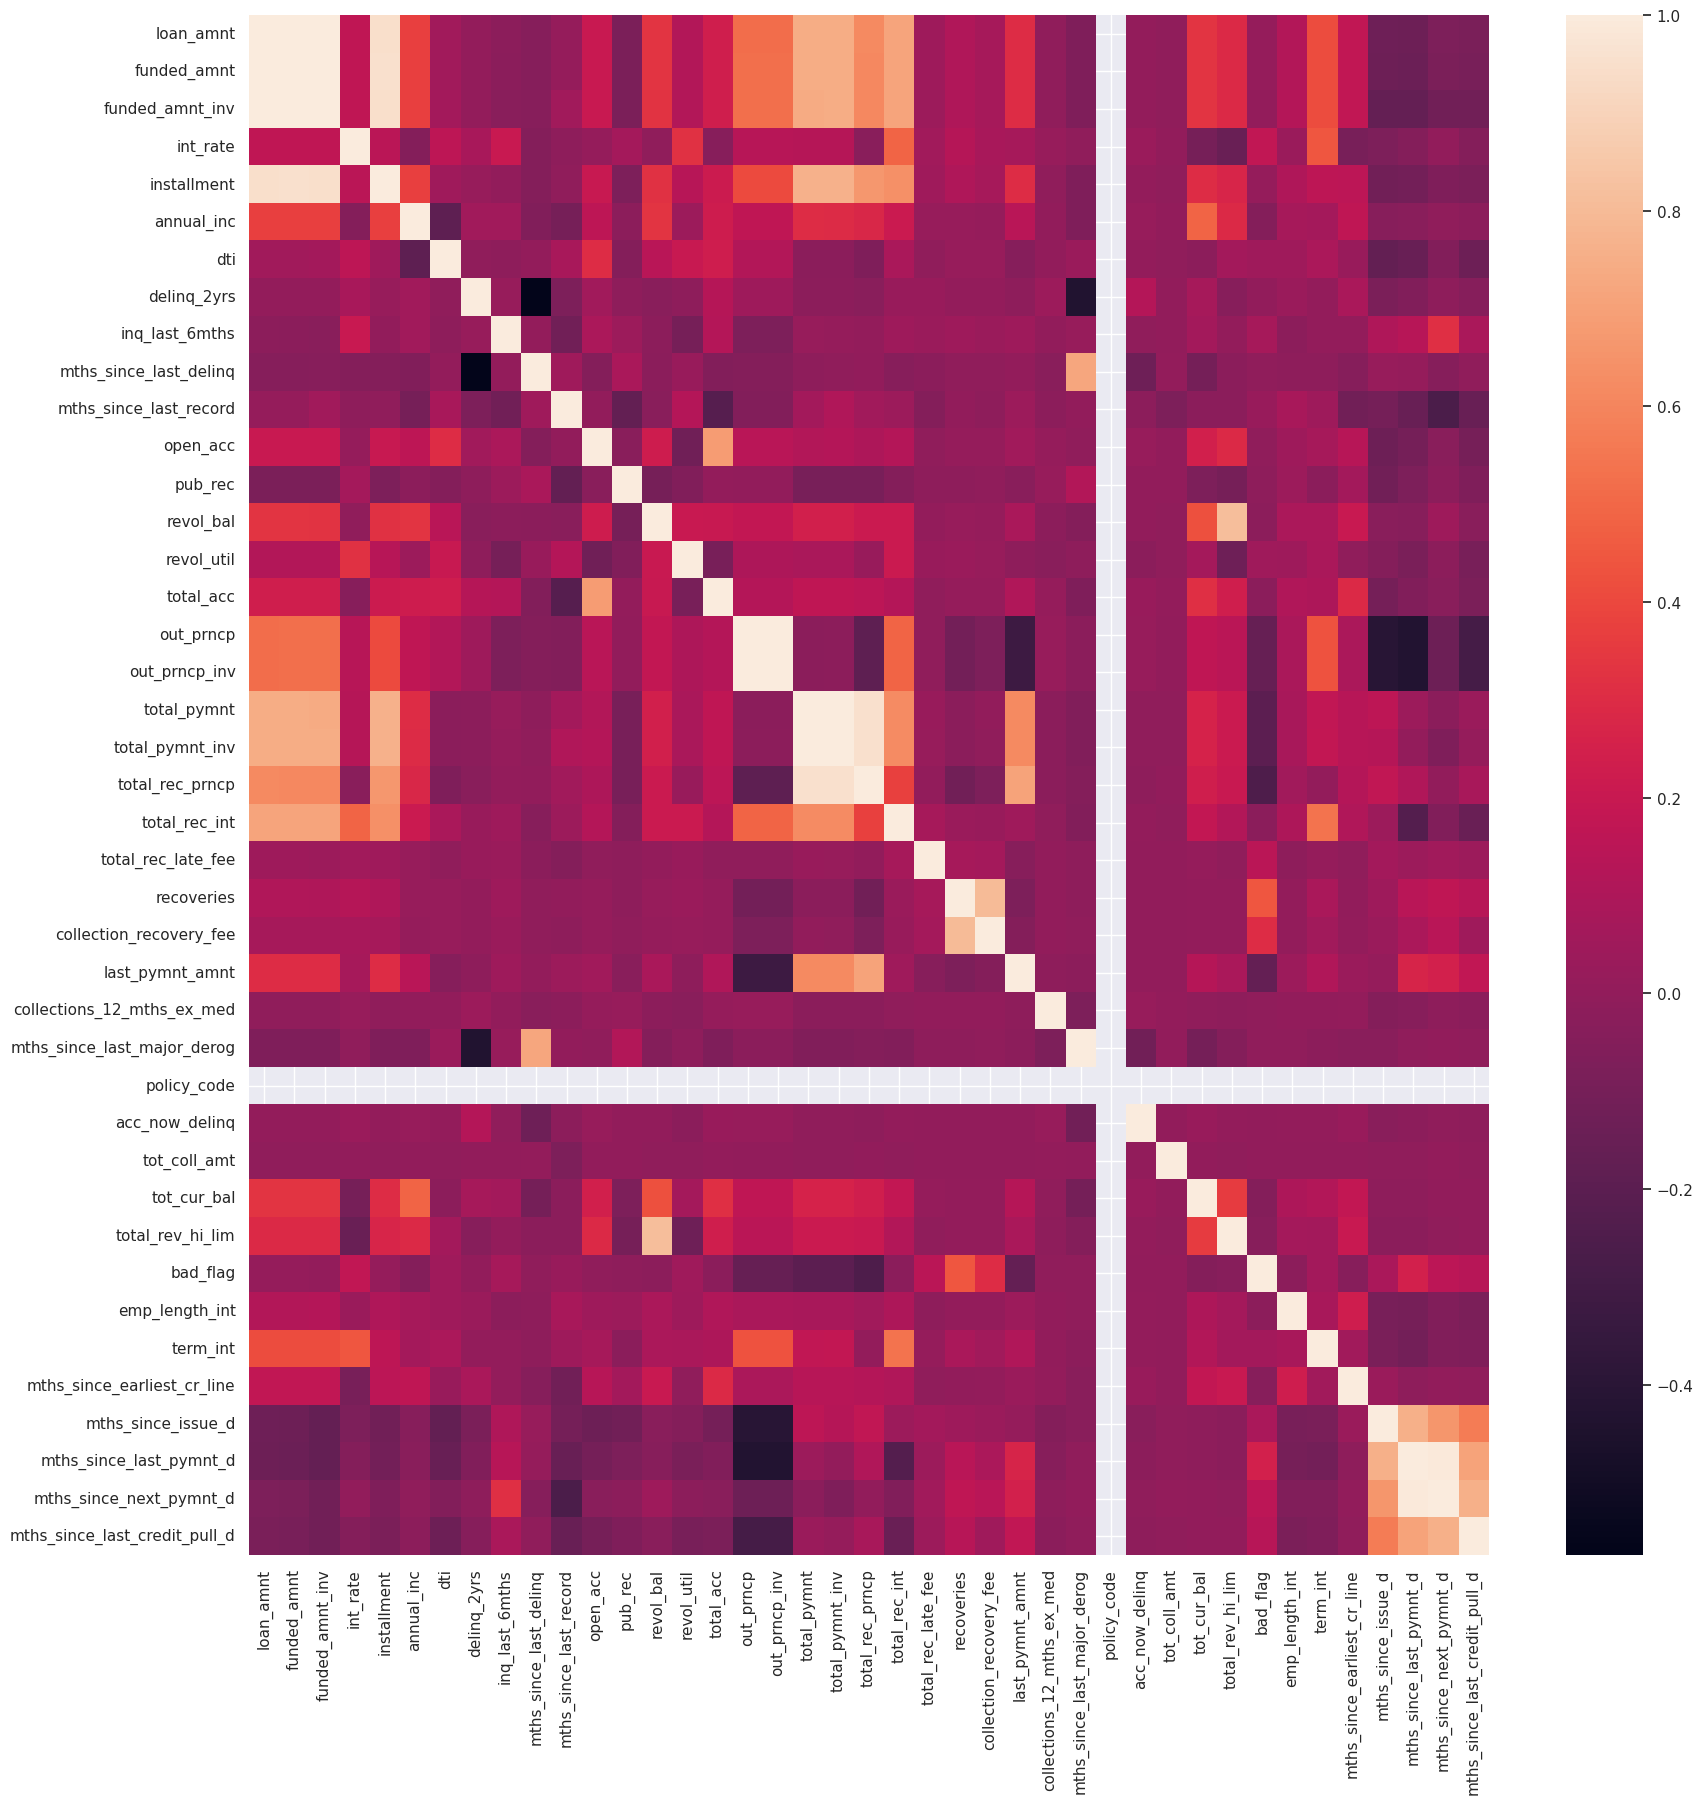

In [ ]:
plt.figure(figsize=(20,20))
sns.heatmap(data.corr())

Di sini, jika ada pasangan fitur-fitur yang memiliki korelasi tinggi maka akan diambil salah satu saja. Nilai korelasi yang dijadikan patokan sebagai korelasi tinggi tidak pasti, umumnya digunakan angka 0.7.

In [ ]:
corr_matrix = data.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop_hicorr = [column for column in upper.columns if any(upper[column] > 0.7)]

In [ ]:
to_drop_hicorr

['funded_amnt',
 'funded_amnt_inv',
 'installment',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'collection_recovery_fee',
 'last_pymnt_amnt',
 'mths_since_last_major_derog',
 'total_rev_hi_lim',
 'mths_since_last_pymnt_d',
 'mths_since_next_pymnt_d',
 'mths_since_last_credit_pull_d']

In [ ]:
data.drop(to_drop_hicorr, axis=1, inplace=True)

### Check Categorical Features

In [ ]:
data.select_dtypes(include='object').nunique()

grade                       7
emp_title              205475
home_ownership              6
verification_status         3
pymnt_plan                  2
purpose                    14
title                   63099
addr_state                 50
initial_list_status         2
application_type            1
dtype: int64

Pada tahap ini dilakukan pembuangan fitur yang memiliki nilai unik yang sangat tinggi (high cardinality) dan fitur yang hanya memiliki satu nilai unik saja.

In [ ]:
data.drop(['emp_title', 'title', 'application_type'], axis=1, inplace=True)

In [ ]:
data.select_dtypes(exclude='object').nunique()

loan_amnt                        1352
int_rate                          506
annual_inc                      31901
dti                              3997
delinq_2yrs                        24
inq_last_6mths                     28
mths_since_last_delinq            145
mths_since_last_record            123
open_acc                           62
pub_rec                            26
revol_bal                       58142
revol_util                       1269
total_acc                         112
out_prncp                      135665
total_rec_late_fee               5808
recoveries                      22773
collections_12_mths_ex_med          9
policy_code                         1
acc_now_delinq                      6
tot_coll_amt                     6321
tot_cur_bal                    220690
bad_flag                            2
emp_length_int                     11
term_int                            2
mths_since_earliest_cr_line       664
mths_since_issue_d                 91
dtype: int64

Ternyata, pada tipe data selain `object` juga terdapat fitur yang hanya memiliki satu nilai unik saja, maka akan ikut dibuang juga.

In [ ]:
data.drop(['policy_code'], axis=1, inplace=True)

In [ ]:
for col in data.select_dtypes(include='object').columns.tolist():
    print(data[col].value_counts(normalize=True)*100)
    print('\n')

B    29.365946
C    26.870476
D    16.489486
A    16.056060
E     7.668486
F     2.837106
G     0.712440
Name: grade, dtype: float64


MORTGAGE    50.586015
RENT        40.420129
OWN          8.943886
OTHER        0.039032
NONE         0.010723
ANY          0.000214
Name: home_ownership, dtype: float64


Verified           36.041262
Source Verified    32.167666
Not Verified       31.791072
Name: verification_status, dtype: float64


n    99.99807
y     0.00193
Name: pymnt_plan, dtype: float64


debt_consolidation    58.804165
credit_card           22.337626
home_improvement       5.691155
other                  5.080584
major_purchase         2.107724
small_business         1.504016
car                    1.157447
medical                0.986950
moving                 0.642097
vacation               0.533365
wedding                0.502482
house                  0.486612
educational            0.090503
renewable_energy       0.075276
Name: purpose, dtype: float64


CA    15.323247
NY  

Fitur yang sangat didominasi oleh salah satu nilai saja akan dibuang pada tahap ini.

In [ ]:
data.drop('pymnt_plan', axis=1, inplace=True)

# Missing Values

### Missing Value Checking

In [ ]:
check_missing = data.isnull().sum() * 100 / data.shape[0]
check_missing[check_missing > 0].sort_values(ascending=False)

mths_since_last_record         86.566585
mths_since_last_delinq         53.690554
tot_coll_amt                   15.071469
tot_cur_bal                    15.071469
emp_length_int                  4.505399
revol_util                      0.072917
collections_12_mths_ex_med      0.031097
delinq_2yrs                     0.006219
inq_last_6mths                  0.006219
open_acc                        0.006219
pub_rec                         0.006219
total_acc                       0.006219
acc_now_delinq                  0.006219
mths_since_earliest_cr_line     0.006219
annual_inc                      0.000858
dtype: float64

Di sini, kolom-kolom dengan missing values di atas 75% dibuang

In [ ]:
data.drop('mths_since_last_record', axis=1, inplace=True)

### Missing Values Filling

In [ ]:
data['annual_inc'].fillna(data['annual_inc'].mean(), inplace=True)
data['mths_since_earliest_cr_line'].fillna(0, inplace=True)
data['acc_now_delinq'].fillna(0, inplace=True)
data['total_acc'].fillna(0, inplace=True)
data['pub_rec'].fillna(0, inplace=True)
data['open_acc'].fillna(0, inplace=True)
data['inq_last_6mths'].fillna(0, inplace=True)
data['delinq_2yrs'].fillna(0, inplace=True)
data['collections_12_mths_ex_med'].fillna(0, inplace=True)
data['revol_util'].fillna(0, inplace=True)
data['emp_length_int'].fillna(0, inplace=True)
data['tot_cur_bal'].fillna(0, inplace=True)
data['tot_coll_amt'].fillna(0, inplace=True)
data['mths_since_last_delinq'].fillna(-1, inplace=True)

# Feature Scaling and Transformation

### One Hot Encoding

Semua kolom kategorikal dilakukan One Hot Encoding.

In [ ]:
categorical_cols = [col for col in data.select_dtypes(include='object').columns.tolist()]

In [ ]:
onehot = pd.get_dummies(data[categorical_cols], drop_first=True)

In [ ]:
onehot.head()

,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_w
0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Standardization

Semua kolom numerikal dilakukan proses standarisasi dengan StandardScaler.

In [ ]:
numerical_cols = [col for col in data.columns.tolist() if col not in categorical_cols + ['bad_flag']]

In [ ]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
std = pd.DataFrame(ss.fit_transform(data[numerical_cols]), columns=numerical_cols)

In [ ]:
std.head()

,loan_amnt,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,total_rec_late_fee,recoveries,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,emp_length_int,term_int,mths_since_earliest_cr_line,mths_since_issue_d
0,-1.124392,-0.729587,-0.896551,1.328632,-0.357012,0.178920,-0.708792,-1.641166,-0.31429,-0.124888,1.159498,-1.384557,-0.693944,-0.123464,-0.154549,-0.083608,-0.058307,-0.012089,-0.792648,1.138605,-0.616225,1.754215,1.446626
1,-1.426088,0.330634,-0.787387,-2.065791,-0.357012,3.843328,-0.708792,-1.641166,-0.31429,-0.703378,-1.965980,-1.815538,-0.693944,-0.123464,0.057470,-0.083608,-0.058307,-0.012089,-0.792648,-1.523744,1.622784,-0.212497,1.446626
2,-1.438156,0.488979,-1.110294,-1.082491,-0.357012,1.095022,-0.708792,-1.841641,-0.31429,-0.642003,1.782070,-1.298361,-0.693944,-0.123464,-0.154549,-0.083608,-0.058307,-0.012089,-0.792648,1.138605,-0.616225,-0.569035,1.446626
3,-0.521001,-0.077850,-0.438063,0.354248,-0.357012,0.178920,0.860811,-0.237839,-0.31429,-0.514224,-1.478018,1.028934,-0.693944,3.099264,-0.154549,-0.083608,-0.058307,-0.012089,-0.792648,1.138605,-0.616225,0.224550,1.446626
4,-1.365749,-0.261438,0.122311,0.091865,-0.357012,-0.737182,0.991612,0.764538,-0.31429,0.558748,-0.094058,1.115130,-0.573268,-0.123464,-0.154549,-0.083608,-0.058307,-0.012089,-0.792648,-1.257509,1.622784,0.236051,1.446626


### Transformed Dataframe

Menggabungkan kembali kolom-kolom hasil transformasi

In [ ]:
data_model = pd.concat([onehot, std, data[['bad_flag']]], axis=1)

# MODELING

### Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X = data_model.drop('bad_flag', axis=1)
y = data_model['bad_flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.shape, X_test.shape

((373028, 99), (93257, 99))

### Training

Kita akan menggunakan algoritma XGBoost untuk pemodelan.

In [ ]:
from xgboost import XGBClassifier

In [ ]:
xgb = XGBClassifier(max_depth=5)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Feature Importance dapat ditampilkan.

In [ ]:
arr_feature_importances = xgb.feature_importances_
arr_feature_names = X_train.columns.values

df_feature_importance = pd.DataFrame(index=range(len(arr_feature_importances)), columns=['feature', 'importance'])
df_feature_importance['feature'] = arr_feature_names
df_feature_importance['importance'] = arr_feature_importances
df_all_features = df_feature_importance.sort_values(by='importance', ascending=False)
df_all_features

,feature,importance
90,recoveries,0.846372
89,total_rec_late_fee,0.014819
77,int_rate,0.009127
96,term_int,0.008981
88,out_prncp,0.006586
75,initial_list_status_w,0.006520
98,mths_since_issue_d,0.006305
76,loan_amnt,0.004655
58,addr_state_NY,0.004477
78,annual_inc,0.004435


### Validation

Untuk mengukur performa model, dua metrik yang umum dipakai dalam dunia credit risk adalah AUC dan KS. Namun, saya juga ingin melihat metrik lain seperti Akurasi, F1-score, Recall dll dari model yang dibuat menggunakan classification report.

In [ ]:
y_pred_proba = xgb.predict_proba(X_test)[:][:,1]

df_actual_predicted = pd.concat([pd.DataFrame(np.array(y_test), columns=['y_actual']), pd.DataFrame(y_pred_proba, columns=['y_pred_proba'])], axis=1)
df_actual_predicted.index = y_test.index

#### AUC

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

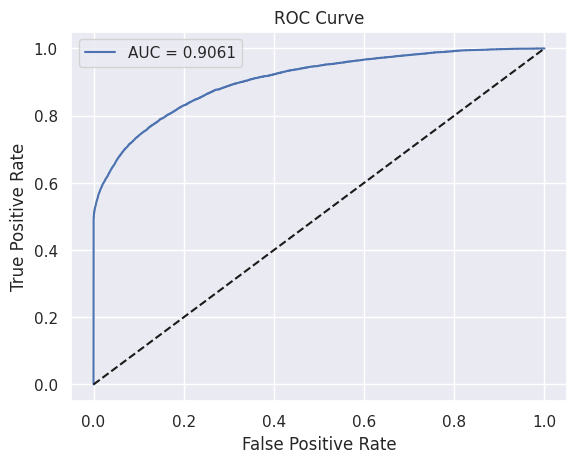

In [ ]:
fpr, tpr, tr = roc_curve(df_actual_predicted['y_actual'], df_actual_predicted['y_pred_proba'])
auc = roc_auc_score(df_actual_predicted['y_actual'], df_actual_predicted['y_pred_proba'])

plt.plot(fpr, tpr, label='AUC = %0.4f' %auc)
plt.plot(fpr, fpr, linestyle = '--', color='k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

#### KS

In [ ]:
df_actual_predicted = df_actual_predicted.sort_values('y_pred_proba')
df_actual_predicted = df_actual_predicted.reset_index()

df_actual_predicted['Cumulative N Population'] = df_actual_predicted.index + 1
df_actual_predicted['Cumulative N Bad'] = df_actual_predicted['y_actual'].cumsum()
df_actual_predicted['Cumulative N Good'] = df_actual_predicted['Cumulative N Population'] - df_actual_predicted['Cumulative N Bad']
df_actual_predicted['Cumulative Perc Population'] = df_actual_predicted['Cumulative N Population'] / df_actual_predicted.shape[0]
df_actual_predicted['Cumulative Perc Bad'] = df_actual_predicted['Cumulative N Bad'] / df_actual_predicted['y_actual'].sum()
df_actual_predicted['Cumulative Perc Good'] = df_actual_predicted['Cumulative N Good'] / (df_actual_predicted.shape[0] - df_actual_predicted['y_actual'].sum())

In [ ]:
df_actual_predicted.head()

,index,y_actual,y_pred_proba,Cumulative N Population,Cumulative N Bad,Cumulative N Good,Cumulative Perc Population,Cumulative Perc Bad,Cumulative Perc Good
0,299261,0,0.000218,1,0,1,0.000011,0.0,0.000012
1,263416,0,0.000393,2,0,2,0.000021,0.0,0.000024
2,236977,0,0.000398,3,0,3,0.000032,0.0,0.000036
3,238424,0,0.000533,4,0,4,0.000043,0.0,0.000048
4,237693,0,0.000585,5,0,5,0.000054,0.0,0.000060


Text(0.5, 1.0, 'Kolmogorov-Smirnov:  0.6422')

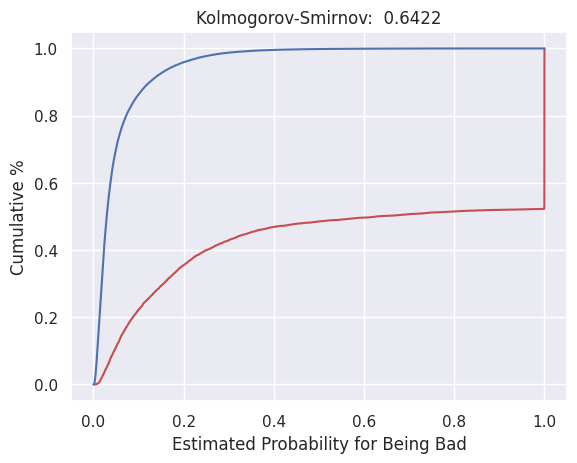

In [ ]:
KS = max(df_actual_predicted['Cumulative Perc Good'] - df_actual_predicted['Cumulative Perc Bad'])

plt.plot(df_actual_predicted['y_pred_proba'], df_actual_predicted['Cumulative Perc Bad'], color='r')
plt.plot(df_actual_predicted['y_pred_proba'], df_actual_predicted['Cumulative Perc Good'], color='b')
plt.xlabel('Estimated Probability for Being Bad')
plt.ylabel('Cumulative %')
plt.title('Kolmogorov-Smirnov:  %0.4f' %KS)

Model yang dibangun menghasilkan performa `AUC = 0.906` dan `KS = 0.642`. Pada dunia credit risk modeling, umumnya AUC di atas 0.7 dan KS di atas 0.3 sudah termasuk performa yang baik.

### Classification Report

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
y_pred = xgb.predict(X_test)

print('Classification_Report:')
print(classification_report(y_test, y_pred, digits=4))

Classification_Report:
              precision    recall  f1-score   support

           0     0.9437    0.9983    0.9702     83067
           1     0.9733    0.5148    0.6734     10190

    accuracy                         0.9454     93257
   macro avg     0.9585    0.7565    0.8218     93257
weighted avg     0.9470    0.9454    0.9378     93257




Model yang telah dibangun menunjukkan tingkat akurasi yang baik sebesar 0.94. Namun, terdapat perbedaan yang signifikan pada nilai recall antara kelas "bad loan" yang hanya mencapai 0.51, sementara kelas "good loan" mencapai 0.99. Indikasi ini menunjukkan kemungkinan terjadinya overfitting pada model. Salah satu faktor yang dapat menyebabkan perbedaan ini adalah ketidakseimbangan data dalam dataset.

# Rekomendasi

Beberapa hal lain yang dapat dilakukan untuk project ini:

- Jika menginginkan interpretabilitas yang lebih tinggi, dapat mempertimbangkan untuk membuat Credit Scorecard dengan menggunakan algoritma Logistic Regression dengan pendekatan-pendekatannya seperti Feature Selection menggunakan Information Value dan Feature Engineering menggunakan Weight of Evidence.

- Melakukan hyperparameter tuning.

- Melakukan pemeriksaan atau memastikan bahwa model yang telah dibuat tidak overfitting. Hal ini dapat dilakukan dengan mencoba membandingkan hasil performa model ketika diprediksi terhadap data training dan ketika diprediksi terhadap data testing.

- Menangani ketidakseimbangan data dengan melakukan oversampling atau undersampling